In [101]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
from domino.slices import collect_settings
from domino.slices.celeba import CelebASliceBuilder
from domino.evaluate import run_sdm, score_sdms
from domino.train import train_settings
import numpy as np
import terra

In [121]:
model_dp, 0 = train_settings.out()

[Artifact(id=210824, run_id=15267, type=<class 'meerkat.datapanel.DataPanel'>),
 Artifact(id=210825, run_id=15267, type=<class 'pandas.core.frame.DataFrame'>)]

In [117]:
import terra.database as tdb
for i in range(100):
    out= tdb.get_runs(fns=train_settings.__name__, statuses="success", limit=1, df=False)
out[0].id

15267

In [28]:
score_df = score_sdms.out().load()

In [30]:
score_df.iloc[score_df.reset_index().groupby(["target", "slice_idx"])['precision_at_10'].idxmax().astype(int)]

,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision,target,run_sdm_run_id
50,0,0,0.737254,0.4,0.36,0.27,0.016949,0.035202,0.071708,0.256845,0.228538,bangs,15080
56,1,1,0.978608,0.3,0.56,0.63,0.033943,0.082245,0.178851,0.849869,0.810710,bangs,15080
21,1,0,0.814091,0.7,0.68,0.52,0.191011,0.292135,0.370787,1.000000,0.033623,brown_hair,15077
27,2,1,0.986306,0.9,0.96,0.80,0.314685,0.559441,0.762238,0.825175,0.143204,brown_hair,15077
30,0,0,0.500000,0.0,0.00,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,eyeglasses,15078
38,3,1,0.990837,0.8,0.88,0.77,0.221106,0.386935,0.663317,0.467337,0.732283,eyeglasses,15078
42,2,0,0.845456,0.6,0.40,0.14,0.151899,0.177215,0.202532,0.455696,0.053333,goatee,15079
85,0,1,0.995191,0.9,0.96,0.78,0.362903,0.629032,0.903226,0.524194,0.812500,goatee,15083
61,1,0,0.655419,0.6,0.56,0.36,0.054974,0.094241,0.138743,0.798429,0.084277,wearing_earrings,15081
67,2,1,0.952113,1.0,0.92,0.73,0.119363,0.193634,0.336870,0.432361,0.348291,wearing_earrings,15081


In [49]:
inp.keys()

dict_keys(['data_dp', 'emb_dp', 'model', 'id_column', 'word_dp', 'sdm_class', 'sdm_config', 'train_model_run_id', 'setting_id', 'corr', 'correlate', 'dataset', 'n', 'slice_category', 'target', 'index', 'parent_run_id', 'build_setting_run_id', 'time_this_iter_s', 'done', 'timesteps_total', 'episodes_total', 'training_iteration', 'experiment_id', 'date', 'timestamp', 'time_total_s', 'pid', 'hostname', 'node_ip', 'time_since_restore', 'timesteps_since_restore', 'iterations_since_restore', 'trial_id', 'config/corr', 'config/correlate', 'config/dataset', 'config/index', 'config/n', 'config/setting_id', 'config/slice_category', 'config/target', 'logdir', 'score_settings_run_id', 'score_model_run_id', 'synthetic_preds'])

In [50]:
inp = run_sdm.inp(run_id=15078, load=True)
print(f"target: {inp['target']}, correlate: {inp['correlate']}")
data_dp, emb_dp = inp["data_dp"], inp["emb_dp"]

data_dp = data_dp.lz[data_dp["split"].isin(["valid", "test"])].merge(
    emb_dp[["image_id", "emb"]], on="image_id"
)

target: eyeglasses, correlate: goatee


In [45]:
from domino.sdm import MixtureModelSDM, SpotlightSDM
sdm = MixtureModelSDM(
    n_slices=5, 
    n_clusters=10, 
    weight_y_log_likelihood=10, 
    init_params="error",
    emb="emb",
    pca_components=128 
)

sdm.fit(data_dp.lz[data_dp["split"] == "valid"])
dp = sdm.transform(data_dp.lz[data_dp["split"] == "test"])

 58%|█████▊    | 58/100 [00:01<00:00, 53.74it/s]


In [46]:
from domino.metrics import compute_sdm_metrics

slice_idx = 1

metrics_df = compute_sdm_metrics(dp)
metrics_df[metrics_df["slice_idx"] == slice_idx].sort_values(
    by="auroc", ascending=False
)


,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision
5,0,1,0.992693,0.8,0.76,0.8,0.201005,0.40201,0.708543,1.0,0.576812
7,2,1,0.013771,0.0,0.00,0.0,0.000000,0.00000,0.000000,0.0,0.000000
9,4,1,0.013531,0.0,0.00,0.0,0.000000,0.00000,0.000000,0.0,0.000000
8,3,1,0.012791,0.0,0.00,0.0,0.000000,0.00000,0.000000,0.0,0.000000
6,1,1,0.011558,0.0,0.00,0.0,0.000000,0.00000,0.000000,0.0,0.000000


In [52]:
from domino.emb.clip import embed_words
pred_slice_idx = 0
words_dp = embed_words.out(14469).load().lz[:int(1.1e4)]
expl_dp = sdm.explain(words_dp=words_dp, data_dp=dp)
expl_dp.lz[(-expl_dp["pred_slices"][:, pred_slice_idx]).argsort()[:10]]

,word (PandasSeriesColumn),pred_slices (NumpyArrayColumn),frequency (PandasSeriesColumn)
0,sessions,"np.ndarray(shape=(5,))",66055
1,elder,"np.ndarray(shape=(5,))",58028
2,economist,"np.ndarray(shape=(5,))",23899
3,govern,"np.ndarray(shape=(5,))",9534
4,pontifical,"np.ndarray(shape=(5,))",9282
5,emeritus,"np.ndarray(shape=(5,))",22397
6,rotary,"np.ndarray(shape=(5,))",12088
7,patriarch,"np.ndarray(shape=(5,))",21551
8,accreditation,"np.ndarray(shape=(5,))",20186
9,corruption,"np.ndarray(shape=(5,))",47778


In [54]:

words_dp = words_dp.view()
slice_proto = (
    np.dot(dp["pred_slices"].T, dp["emb"])
    / dp["pred_slices"].sum(axis=0, keepdims=True).T
)
pred_slice = dp["pred_slices"][:, pred_slice_idx]
slice_proto = dp.lz[pred_slice.argsort()[-10:]]["emb"].mean(axis=0)
#slice_proto = dp.lz[dp["probs"].argsort()[-25:]]["emb"].mean(axis=0)


ref_proto = dp["emb"][dp["target"] == 1].data.mean(axis=0)

words_dp["pred_slices"] = np.dot(
    words_dp["emb"].data, (slice_proto - ref_proto).T
)
expl_dp = words_dp[["word", "pred_slices", "frequency"]]
expl_dp.lz[(-expl_dp["pred_slices"]).argsort()[:10]]

,word (PandasSeriesColumn),pred_slices (NumpyArrayColumn),frequency (PandasSeriesColumn)
0,sessions,0.928223,66055
1,shining,0.913574,11109
2,govern,0.895020,9534
3,elder,0.820801,58028
4,emeritus,0.774902,22397
5,inherit,0.727051,7190
6,pollock,0.720215,6019
7,statesman,0.695312,11756
8,willie,0.600586,24350
9,poppy,0.581055,5898


In [149]:
dp["probs"]

,(NumpyArrayColumn)
0,0.572671
1,0.002813
2,0.289787
3,0.471853
4,0.808809
...,...
6260,0.000028
6261,0.335455
6262,0.000874
6263,0.064662


,image_id (PandasSeriesColumn),identity (PandasSeriesColumn),file (PandasSeriesColumn),5_o_clock_shadow (PandasSeriesColumn),arched_eyebrows (PandasSeriesColumn),attractive (PandasSeriesColumn),bags_under_eyes (PandasSeriesColumn),bald (PandasSeriesColumn),bangs (PandasSeriesColumn),big_lips (PandasSeriesColumn),big_nose (PandasSeriesColumn),black_hair (PandasSeriesColumn),blond_hair (PandasSeriesColumn),blurry (PandasSeriesColumn),brown_hair (PandasSeriesColumn),bushy_eyebrows (PandasSeriesColumn),chubby (PandasSeriesColumn),double_chin (PandasSeriesColumn),eyeglasses (PandasSeriesColumn),goatee (PandasSeriesColumn),gray_hair (PandasSeriesColumn),heavy_makeup (PandasSeriesColumn),high_cheekbones (PandasSeriesColumn),male (PandasSeriesColumn),mouth_slightly_open (PandasSeriesColumn),mustache (PandasSeriesColumn),narrow_eyes (PandasSeriesColumn),no_beard (PandasSeriesColumn),oval_face (PandasSeriesColumn),pale_skin (PandasSeriesColumn),pointy_nose (PandasSeriesColumn),receding_hairline (PandasSeriesColumn),rosy_cheeks (PandasSeriesColumn),sideburns (PandasSeriesColumn),smiling (PandasSeriesColumn),straight_hair (PandasSeriesColumn),wavy_hair (PandasSeriesColumn),wearing_earrings (PandasSeriesColumn),wearing_hat (PandasSeriesColumn),wearing_lipstick (PandasSeriesColumn),wearing_necklace (PandasSeriesColumn),wearing_necktie (PandasSeriesColumn),young (PandasSeriesColumn),img_path (PandasSeriesColumn),index (PandasSeriesColumn),image (ImageColumn),slices (NumpyArrayColumn),target (NumpyArrayColumn),correlate (NumpyArrayColumn),probs (NumpyArrayColumn),split (PandasSeriesColumn),emb (NumpyArrayColumn),pred_slices (NumpyArrayColumn)
0,116204.jpg,10140.0,116204.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/home/common/datasets/celeba/img_align_celeba/116204.jpg,7173,,"np.ndarray(shape=(2,))",0.0,1.0,4.951301e-01,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
1,098610.jpg,10140.0,098610.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/home/common/datasets/celeba/img_align_celeba/098610.jpg,7173,,"np.ndarray(shape=(2,))",0.0,1.0,7.636984e-01,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
2,097363.jpg,3954.0,097363.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/home/common/datasets/celeba/img_align_celeba/097363.jpg,3816,,"np.ndarray(shape=(2,))",0.0,1.0,8.906331e-01,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
3,108593.jpg,3954.0,108593.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/home/common/datasets/celeba/img_align_celeba/108593.jpg,3816,,"np.ndarray(shape=(2,))",0.0,1.0,9.998295e-01,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
4,147479.jpg,3954.0,147479.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/home/common/datasets/celeba/img_align_celeba/147479.jpg,3816,,"np.ndarray(shape=(2,))",0.0,1.0,2.006541e-01,test,"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,157945.jpg,7810.0,157945.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/home/common/datasets/celeba/img_align_celeba/157945.jpg,2817,,"np.ndarray(shape=(2,))",0.0,0.0,2.373349e-07,test,"np.ndarray(shape=(512,))","np.nda
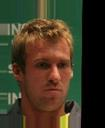
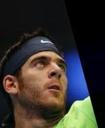
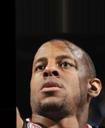
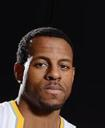
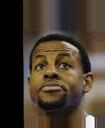
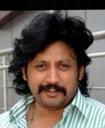
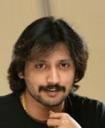
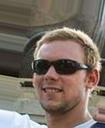
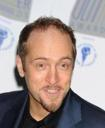
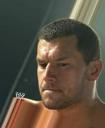

In [193]:

dp.lz[dp["target"] == 0]#[["object_image", "target", "slice"]]

,image_id (PandasSeriesColumn),identity (PandasSeriesColumn),file (PandasSeriesColumn),5_o_clock_shadow (PandasSeriesColumn),arched_eyebrows (PandasSeriesColumn),attractive (PandasSeriesColumn),bags_under_eyes (PandasSeriesColumn),bald (PandasSeriesColumn),bangs (PandasSeriesColumn),big_lips (PandasSeriesColumn),big_nose (PandasSeriesColumn),black_hair (PandasSeriesColumn),blond_hair (PandasSeriesColumn),blurry (PandasSeriesColumn),brown_hair (PandasSeriesColumn),bushy_eyebrows (PandasSeriesColumn),chubby (PandasSeriesColumn),double_chin (PandasSeriesColumn),eyeglasses (PandasSeriesColumn),goatee (PandasSeriesColumn),gray_hair (PandasSeriesColumn),heavy_makeup (PandasSeriesColumn),high_cheekbones (PandasSeriesColumn),male (PandasSeriesColumn),mouth_slightly_open (PandasSeriesColumn),mustache (PandasSeriesColumn),narrow_eyes (PandasSeriesColumn),no_beard (PandasSeriesColumn),oval_face (PandasSeriesColumn),pale_skin (PandasSeriesColumn),pointy_nose (PandasSeriesColumn),receding_hairline (PandasSeriesColumn),rosy_cheeks (PandasSeriesColumn),sideburns (PandasSeriesColumn),smiling (PandasSeriesColumn),straight_hair (PandasSeriesColumn),wavy_hair (PandasSeriesColumn),wearing_earrings (PandasSeriesColumn),wearing_hat (PandasSeriesColumn),wearing_lipstick (PandasSeriesColumn),wearing_necklace (PandasSeriesColumn),wearing_necktie (PandasSeriesColumn),young (PandasSeriesColumn),img_path (PandasSeriesColumn),index (PandasSeriesColumn),image (ImageColumn),slices (NumpyArrayColumn),target (NumpyArrayColumn),correlate (NumpyArrayColumn),id (PandasSeriesColumn),split (PandasSeriesColumn),input (LambdaColumn),output (ClassificationOutputColumn),layer4 (TensorColumn),probs (ClassificationOutputColumn),emb (NumpyArrayColumn),pred_slices (NumpyArrayColumn)
0,121031.jpg,4765,121031.jpg,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,/home/common/datasets/celeba/img_align_celeba/121031.jpg,2561,,"np.ndarray(shape=(2,))",1,0,121031.jpg,test,LambdaCell(fn=default_transform),torch.Tensor(shape=torch.Size([2])),torch.Tensor(shape=torch.Size([512])),torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
1,136681.jpg,9683,136681.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/home/common/datasets/celeba/img_align_celeba/136681.jpg,4818,,"np.ndarray(shape=(2,))",1,1,136681.jpg,test,LambdaCell(fn=default_transform),torch.Tensor(shape=torch.Size([2])),torch.Tensor(shape=torch.Size([512])),torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
2,178569.jpg,2523,178569.jpg,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,/home/common/datasets/celeba/img_align_celeba/178569.jpg,8578,,"np.ndarray(shape=(2,))",1,1,178569.jpg,test,LambdaCell(fn=default_transform),torch.Tensor(shape=torch.Size([2])),torch.Tensor(shape=torch.Size([512])),torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
3,108842.jpg,3265,108842.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,1,1,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,/home/common/datasets/celeba/img_align_celeba/108842.jpg,4229,,"np.ndarray(shape=(2,))",1,0,108842.jpg,test,LambdaCell(fn=default_transform),torch.Tensor(shape=torch.Size([2])),torch.Tensor(shape=torch.Size([512])),torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
4,067002.jpg,282,067002.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,/home/common/datasets/celeba/img_align_celeba/067002.jpg,7600,,"np.ndarray(shape=(2,))",1,0,067002.jpg,test,LambdaCell(fn=default_transform),torch.Tensor(shape=torch.Size([2])),torch.Tensor(shape=torch.Size([512])),torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))","np.ndarray(shape=(5,))"
5,007656.jpg,3177,007656.jpg,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,/home/common/datasets/celeba/img_align_celeba/007656.jpg,3386,,"
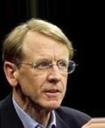
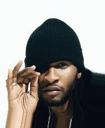
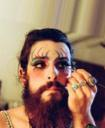
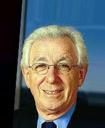
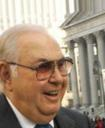
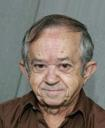
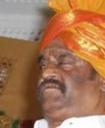
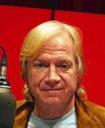
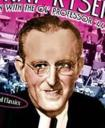
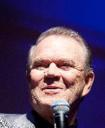

In [55]:

dp.lz[dp["pred_slices"].data[:, pred_slice_idx].argsort()[-10:]]#[["object_image", "target", "slice"]]

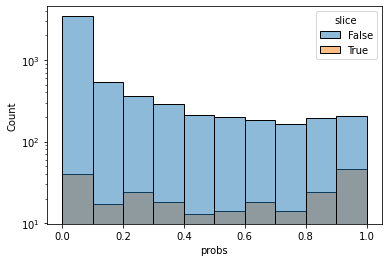

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plot_df = pd.DataFrame(
    {"probs": dp["probs"], "slice": dp["slices"][:, slice_idx], "target": dp["target"]}
)
sns.histplot(
    data=plot_df[plot_df["target"] == 0],
    x="probs",
    hue="slice",
    stat="count",
    common_norm=not False,
    binwidth=0.1,
)
plt.yscale("log")


In [6]:
from domino.train import score_settings, train_settings, score_model, train_model

In [5]:
score_settings.out().load()["score_model_run_id"]

,(PandasSeriesColumn)
0,15006
1,15007
2,15008
3,15005
4,15009
5,15010
6,15011
7,15012
8,15014
9,15013


In [8]:
score_dp = score_model.out(15006).load()

In [18]:
from sklearn.metrics import roc_auc_score
mask = score_dp["target"] != score_dp["correlate"]
roc_auc_score(score_dp.lz[mask]["target"], score_dp.lz[mask]["probs"][:, 1])

0.26252927075972343

In [13]:
score_dp["probs"] = score_dp["output"].probabilities()

In [10]:
from domino.train import score_settings, synthetic_score_settings, score_model

In [5]:
type(synthetic_score_settings.out().load())

meerkat.datapanel.DataPanel

In [19]:
score_settings.out()[0].load()

,train_model_run_id (PandasSeriesColumn),setting_id (NumpyArrayColumn),corr (NumpyArrayColumn),correlate (PandasSeriesColumn),dataset (PandasSeriesColumn),n (NumpyArrayColumn),slice_category (PandasSeriesColumn),target (PandasSeriesColumn),index (PandasSeriesColumn),parent_run_id (PandasSeriesColumn),build_setting_run_id (PandasSeriesColumn),time_this_iter_s (PandasSeriesColumn),done (PandasSeriesColumn),timesteps_total (PandasSeriesColumn),episodes_total (PandasSeriesColumn),training_iteration (PandasSeriesColumn),experiment_id (PandasSeriesColumn),date (PandasSeriesColumn),timestamp (PandasSeriesColumn),time_total_s (PandasSeriesColumn),pid (PandasSeriesColumn),hostname (PandasSeriesColumn),node_ip (PandasSeriesColumn),time_since_restore (PandasSeriesColumn),timesteps_since_restore (PandasSeriesColumn),iterations_since_restore (PandasSeriesColumn),trial_id (PandasSeriesColumn),config/corr (PandasSeriesColumn),config/correlate (PandasSeriesColumn),config/dataset (PandasSeriesColumn),config/index (PandasSeriesColumn),config/n (PandasSeriesColumn),config/setting_id (PandasSeriesColumn),config/slice_category (PandasSeriesColumn),config/target (PandasSeriesColumn),logdir (PandasSeriesColumn),score_settings_run_id (PandasSeriesColumn),score_model_run_id (PandasSeriesColumn),synthetic_preds (PandasSeriesColumn)
0,14936,163,0.6,blond_hair,celeba,30000,correlation,wearing_necklace,0,14928,14930,1112.037066,False,NaN,NaN,1,8ef98aebaa294f1f8875ae337af348ea,2021-09-22_12-08-35,1632312515,1112.037066,198,run-script-nf5ts,10.92.1.25,1112.037066,0,1,36c4b_00000,0.6,blond_hair,celeba,163,30000,163,correlation,wearing_necklace,"/root/ray_results/_train_model_2021-09-22_11-49-59/_train_model_36c4b_00000_0_config={'corr': 0.6000000000000001, 'correlate': 'blond_hair', 'dataset': 'celeba', 'n': 30000, 'slice__2021-09-22_11-49-59",15044,15045,False
1,14933,139,0.8,eyeglasses,celeba,30000,correlation,wearing_hat,1,14928,14931,1116.230135,False,NaN,NaN,1,20a0c9441e584990983fc829547b6915,2021-09-22_12-08-39,1632312519,1116.230135,196,run-script-nf5ts,10.92.1.25,1116.230135,0,1,36c4b_00001,0.8,eyeglasses,celeba,139,30000,139,correlation,wearing_hat,"/root/ray_results/_train_model_2021-09-22_11-49-59/_train_model_36c4b_00001_1_config={'corr': 0.8, 'correlate': 'eyeglasses', 'dataset': 'celeba', 'n': 30000, 'slice_category': 'cor_2021-09-22_11-49-59",15044,15046,False


In [24]:
score_model.out(15045)[0].load()["split"].unique()

array(['train', 'valid'], dtype=object)

In [56]:
from domino.data.celeba import get_celeba_dp

In [96]:
sb = CelebASliceBuilder()
out = sb.build_rare_setting(
    data_dp=get_celeba_dp.out().load(),
    target_attrs=["wearing_earrings", "male", "blond_hair"],
    slice_attrs=["blond_hair"],
    slice_frac=0.01,
    target_frac=0.5,
    n=20_000
)

In [99]:
out["wearing_earrings"].mean()

0.1394

In [84]:
np.any(out == 1, axis=0).mean()

0.7881282730911802

In [73]:
 data_dp=get_celeba_dp.out().load()

In [85]:
target_attrs=["wearing_earrings", "male", "blond_hair"]

targets = np.array(
            [data_dp[attr] for attr in target_attrs]
)


In [100]:
train_settings.out()

NameError: name 'train_settings' is not defined